In [65]:
!nvidia-smi

Sat Jun  3 23:11:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:B1:00.0 Off |                  N/A |
| 22%   24C    P8     5W / 250W |  11007MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:B2:00.0 Off |                  N/A |
| 22%   

In [66]:
import os
import torch

os.environ['CUDA_VISIBLE_DEVICES'] = "2,3"

ngpu = torch.cuda.device_count()
for gpu_id in range(ngpu):
    gpu = torch.cuda.get_device_name(gpu_id)
    print(f"GPU:{gpu_id} {gpu}")

GPU:0 NVIDIA GeForce RTX 2080 Ti
GPU:1 NVIDIA GeForce RTX 2080 Ti


In [67]:
import sys
from PIL import Image, ImageDraw
import imageio
import torch.nn as nn
from torchvision import transforms
from matplotlib import pyplot as plt
import numpy as np
import timm
from timm.models.vision_transformer import trunc_normal_

In [68]:
def rollout(attentions, discard_ratio, head_fusion):
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        
        for attention in attentions: # Attention shape: (1, 3, 197, 197)
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0] # # shape: (1, 197, 197)
                # print(f"Shape before max is {attention.shape}, After: {attention.max(axis=1)}")
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Pick a proper head fusion mode"

            # Drop the lowest attentions, but
            # don't drop the class token
            # print(f"attention heads fused size : {attention_heads_fused.size(0)}")
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1) # Shape : (1, 197*197)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            # print(sum(1 if i == 0 else 0 for i in indices[0]))
            # print(indices.shape)
            indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1) # Shape : (1, 197, 197)
            a = a[0]

            result = torch.matmul(a, result) # Shape: (1, 197, 197)
                                             # How much information do we get from the token j
                                             # in prev. layer (result) into the token i here (a)
    
    # Look at the total attention between the class token,
    # and the image patches
    mask = result[0, 1:] # Shape : (196)
    
    # In case of 224x224 image, this brings us from 196 to 14
    width = int(mask.size(-1)**0.5)
    mask = mask.reshape(width, width).numpy() # Shape : (14, 14)
    mask = mask / np.max(mask)
    return mask    

class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='attn_drop', head_fusion="mean",
        discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(input_tensor)

        return rollout(self.attentions, self.discard_ratio, self.head_fusion), output

In [69]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

model = torch.hub.load('facebookresearch/deit:main',  'deit_tiny_patch16_224', pretrained=True).to(device)
model.eval()

gpu_reference_tensor = next(model.parameters())

classes = open("classes.txt").read().splitlines()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

Using cache found in /home/hashimi/.cache/torch/hub/facebookresearch_deit_main


224

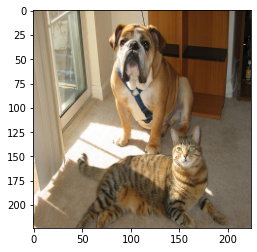

In [89]:
# Writing DAUC and IAUC code here...
img_path = './examples/input.png'
img = Image.open(img_path)
img = img.resize((224, 224))


input_tensor = transform(img).unsqueeze(0)
input_tensor = input_tensor.type_as(gpu_reference_tensor)

head_fusion = 'max'
discard_ratio = 0.9
attention_rollout = VITAttentionRollout(model, head_fusion=head_fusion, 
                                        discard_ratio=discard_ratio)
mask, output = attention_rollout(input_tensor)

probs = torch.nn.functional.softmax(output, dim=1)
cat_idx = torch.argmax(probs).item()
# print(cat_idx) # Bulldog is 243

np_img = np.array(img)
heatmap = Image.fromarray(mask)
# heatmap = np.array(heatmap.resize((np_img.shape[0], np_img.shape[1])))
# # plt.imshow(np_img)
# heatmap = (heatmap / np.max(heatmap)) * 255.0
# plt.imshow(heatmap, cmap='turbo', # seismic, hot, Reds
#                     alpha=1)
# plt.title(f"Class: {classes[cat_idx]} ({probs[0, cat_idx].item()*100:.2f}%)")
# plt.show()
plt.imshow(np_img)
img.size[0]

area = 1.0


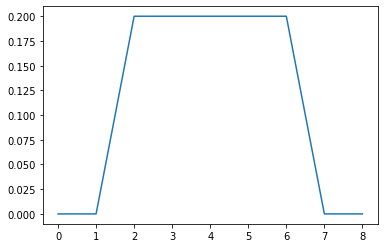

In [86]:
def DAUC(img, saliency, PropX, PropY):
    for X in img.size[0]:
        for Y in img.size[1]:
            if 


from numpy import trapz
y = np.array([0, 0, 0.2, 0.2, 0.2, 0.2, 0.2, 0, 0])

# Compute the area using the composite trapezoidal rule.
area = trapz(y)
plt.plot(y)
print("area =", area)

In [72]:
bin_freq, bin_vals = np.histogram(np.array(heatmap), 20)

In [73]:
len(bin_vals)

21

In [ ]:
# dir_path = './examples'
# row = 0
# col = 0
# fig, ax = plt.subplots(2, 2, figsize=(10, 10))
# for idx, image_file in enumerate(os.listdir(dir_path)):
#     if idx > 4:
#         break
#     if os.path.isfile(os.path.join(dir_path, image_file)):
#         img = Image.open(os.path.join(dir_path, image_file))
#         img = img.resize((224, 224))
#         input_tensor = transform(img).unsqueeze(0)
#         input_tensor = input_tensor.type_as(gpu_reference_tensor)

#         category_index = None
#         head_fusion = 'max'
#         discard_ratio = 0.9
#         attention_rollout = VITAttentionRollout(model, head_fusion=head_fusion, 
#                 discard_ratio=discard_ratio)
#         mask, output = attention_rollout(input_tensor)
        
#         probs = torch.nn.functional.softmax(output, dim=1)
#         cat_idx = torch.argmax(probs).item()
#         # print(cat_idx)
        
#         np_img = np.array(img)
#         heatmap = Image.fromarray(mask)
#         heatmap = np.array(heatmap.resize((np_img.shape[0], np_img.shape[1])))
#         ax[row, col].imshow(np_img)
#         heatmap = (heatmap / np.max(heatmap)) * 255.0
#         ax[row, col].imshow(heatmap, cmap='turbo', # seismic, hot, Reds
#                   alpha=0.5)
#         ax[row, col].set_title(f"Class: {classes[cat_idx]} ({probs[0, cat_idx].item()*100:.2f}%)")
        
#         if col == 1:
#             row += 1
#             col = 0
#         else: col += 1
# plt.show()

In [32]:
torch.__version__

'1.13.1+cu117'